In [41]:
import pandas as pd
import sqlite3
from tabulate import tabulate

try:
    payments_df = pd.read_csv('payments.csv')
    customer_orders_df = pd.read_csv('customer_orders.csv')
    print("Datasets loaded successfully!")
    print("\nPayments Data:")
    print(tabulate(payments_df.head(), headers='keys', tablefmt='grid'))
    print("\nCustomer Orders Data:")
    print(tabulate(customer_orders_df.head(), headers='keys', tablefmt='grid'))
except FileNotFoundError:
    print("Error: One or both CSV files not found")

conn = None
try:
    conn = sqlite3.connect('alt_mobility_data.db')
    payments_df.to_sql('payments', conn, if_exists='replace', index=False)
    customer_orders_df.to_sql('customer_orders', conn, if_exists='replace', index=False)
    print("\nData loaded into SQLite database 'alt_mobility_data.db'")
except Exception as e:
    print(f"Error loading data into SQLite: {e}")
finally:
    if conn:
        conn.close()

Datasets loaded successfully!

Payments Data:
+----+--------------------------------------+--------------------------------------+----------------+------------------+------------------+------------------+
|    | payment_id                           | order_id                             | payment_date   |   payment_amount | payment_method   | payment_status   |
+====+======================================+======================================+================+==================+==================+==================+
|  0 | 5613f6af-53cc-46b7-a532-a388055c6995 | 3518bcc6-fbd5-469d-a3c1-3ee4961c9dbd | 2024-05-16     |           401.18 | paypal           | completed        |
+----+--------------------------------------+--------------------------------------+----------------+------------------+------------------+------------------+
|  1 | 2b3f3fc4-facd-49e1-b190-02adca7d5e8b | 303e6532-25c9-4c1e-9297-557fd37415f6 | 2023-03-19     |           293.31 | paypal           | completed        |


In [2]:
import sqlite3


conn = sqlite3.connect('alt_mobility_data.db')
cursor = conn.cursor()


## Order and Sales Analysis

In [35]:
import sqlite3
import pandas as pd
from tabulate import tabulate

conn = sqlite3.connect('alt_mobility_data.db')

query = """
SELECT order_status, COUNT(*) AS order_count
FROM customer_orders
GROUP BY order_status
ORDER BY order_count DESC;
"""
order_status_df = pd.read_sql_query(query, conn)
conn.close()

print(tabulate(order_status_df, headers='keys', tablefmt='grid'))

+----+----------------+---------------+
|    | order_status   |   order_count |
+====+================+===============+
|  0 | pending        |          5069 |
+----+----------------+---------------+
|  1 | delivered      |          5057 |
+----+----------------+---------------+
|  2 | shipped        |          4874 |
+----+----------------+---------------+


# Customer Analysis:

In [47]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

conn = sqlite3.connect('alt_mobility_data.db')

# Query for repeat customers
query_repeat_orders = """
SELECT customer_id, COUNT(order_id) AS total_orders
FROM customer_orders
GROUP BY customer_id
HAVING total_orders > 1
ORDER BY total_orders DESC;
"""

repeat_customers_df = pd.read_sql_query(query_repeat_orders, conn)
print("Repeat Customers (More than 1 order):")
print(tabulate(repeat_customers_df.head(10), headers='keys', tablefmt='grid'))
if len(repeat_customers_df) > 10:
    print("...\n...\n...")
    print(tabulate(repeat_customers_df.tail(5), headers='keys', tablefmt='grid'))
print("\n" + "-"*40 + "\n") # Adding a separator for clarity

# Query for customer segments
query_customer_segments = """
SELECT customer_id, COUNT(order_id) AS total_orders
FROM customer_orders
GROUP BY customer_id
ORDER BY total_orders DESC;
"""

customer_segments_df = pd.read_sql_query(query_customer_segments, conn)

def segment_customer_orders(row):
    if row['total_orders'] <= 3:
        return 'Low'
    elif 4 <= row['total_orders'] <= 10:
        return 'Medium'
    else:
        return 'High'

customer_segments_df['segment'] = customer_segments_df.apply(segment_customer_orders, axis=1)

print("Customer Segments (First 5 rows):")
print(tabulate(customer_segments_df.head(), headers='keys', tablefmt='grid'))
print("\n" + "-"*40 + "\n")

#Query for trends over time
query_trends_over_time = """
SELECT strftime('%Y-%m', order_date) AS order_month, COUNT(order_id) AS total_orders
FROM customer_orders
GROUP BY order_month
ORDER BY order_month;
"""

monthly_trends_df = pd.read_sql_query(query_trends_over_time, conn)

print("Monthly Order Trends:")
print(tabulate(monthly_trends_df, headers='keys', tablefmt='grid'))
print("\n" + "-"*40 + "\n")


conn.close()

Repeat Customers (More than 1 order):
+----+---------------+----------------+
|    |   customer_id |   total_orders |
+====+===============+================+
|  0 |          2633 |              8 |
+----+---------------+----------------+
|  1 |          9955 |              7 |
+----+---------------+----------------+
|  2 |          9476 |              7 |
+----+---------------+----------------+
|  3 |          9243 |              7 |
+----+---------------+----------------+
|  4 |          8231 |              7 |
+----+---------------+----------------+
|  5 |          8045 |              7 |
+----+---------------+----------------+
|  6 |          7493 |              7 |
+----+---------------+----------------+
|  7 |          7208 |              7 |
+----+---------------+----------------+
|  8 |          6477 |              7 |
+----+---------------+----------------+
|  9 |          6006 |              7 |
+----+---------------+----------------+
...
...
...
+------+---------------+------

# Payment Status Analysis:

In [42]:

conn = sqlite3.connect('alt_mobility_data.db')


query = """
WITH customer_first_order AS (
    SELECT
        customer_id,
        MIN(order_date) AS first_order_date
    FROM customer_orders
    GROUP BY customer_id
)

SELECT
    strftime('%Y-%m', first_order_date) AS first_order_month,
    COUNT(customer_id) AS new_customers
FROM customer_first_order
GROUP BY first_order_month
ORDER BY first_order_month;
"""

new_customers_df = pd.read_sql_query(query, conn)
print(new_customers_df)


+----+---------------------+-----------------+
|    | first_order_month   |   new_customers |
+====+=====================+=================+
|  0 | 2020-01             |             241 |
+----+---------------------+-----------------+
|  1 | 2020-02             |             228 |
+----+---------------------+-----------------+
|  2 | 2020-03             |             207 |
+----+---------------------+-----------------+
|  3 | 2020-04             |             200 |
+----+---------------------+-----------------+
|  4 | 2020-05             |             209 |
+----+---------------------+-----------------+
|  5 | 2020-06             |             208 |
+----+---------------------+-----------------+
|  6 | 2020-07             |             206 |
+----+---------------------+-----------------+
|  7 | 2020-08             |             190 |
+----+---------------------+-----------------+
|  8 | 2020-09             |             162 |
+----+---------------------+-----------------+
|  9 | 2020-1

In [43]:
import sqlite3
import pandas as pd
from tabulate import tabulate

conn = sqlite3.connect('alt_mobility_data.db')

query = """
SELECT payment_status, COUNT(*) AS count
FROM payments
GROUP BY payment_status;
"""

payment_status_df = pd.read_sql_query(query, conn)

conn.close()

print(tabulate(payment_status_df, headers='keys', tablefmt='grid'))

+----+------------------+---------+
|    | payment_status   |   count |
+====+==================+=========+
|  0 | completed        |    4991 |
+----+------------------+---------+
|  1 | failed           |    5003 |
+----+------------------+---------+
|  2 | pending          |    5006 |
+----+------------------+---------+


In [44]:
import sqlite3
import pandas as pd
from tabulate import tabulate

conn = sqlite3.connect('alt_mobility_data.db')

query = """
SELECT
    (SUM(CASE WHEN payment_status = 'Failed' THEN 1 ELSE 0 END) * 100.0) / COUNT(*) AS failure_rate_percentage
FROM payments;
"""

payment_failure_rate_df = pd.read_sql_query(query, conn)
conn.close()

print(tabulate(payment_failure_rate_df, headers='keys', tablefmt='grid'))

+----+---------------------------+
|    |   failure_rate_percentage |
+====+===========================+
|  0 |                         0 |
+----+---------------------------+


# Order Details Report:

In [45]:
import sqlite3
import pandas as pd
from tabulate import tabulate

conn = sqlite3.connect('alt_mobility_data.db')

query = """
SELECT
    co.order_id,
    co.customer_id,
    co.order_date,
    co.order_status,
    co.order_amount,
    p.payment_id,
    p.payment_status,
    p.payment_date,
    p.payment_amount
FROM customer_orders co
LEFT JOIN payments p
ON co.order_id = p.order_id
ORDER BY co.order_date;
"""

order_details_report_df = pd.read_sql_query(query, conn)
conn.close()

print(tabulate(order_details_report_df.head(), headers='keys', tablefmt='grid'))

+----+--------------------------------------+---------------+--------------+----------------+----------------+--------------------------------------+------------------+----------------+------------------+
|    | order_id                             |   customer_id | order_date   | order_status   |   order_amount | payment_id                           | payment_status   | payment_date   |   payment_amount |
+====+======================================+===============+==============+================+================+======================================+==================+================+==================+
|  0 | 89500d1d-e14d-4158-9f1d-eb4651678fb9 |          8580 | 2020-01-01   | delivered      |         305.27 | 0bf54484-e70a-42c8-aeb8-29b64f9951ea | pending          | 2023-11-07     |           495.05 |
+----+--------------------------------------+---------------+--------------+----------------+----------------+--------------------------------------+------------------+------------

In [17]:

query = """
SELECT
    strftime('%Y-%m', order_date) AS order_month,
    SUM(order_amount) AS total_sales
FROM customer_orders
GROUP BY order_month
ORDER BY order_month;
"""

monthly_sales_df = pd.read_sql_query(query, conn)


# Customer Retention Analysis:

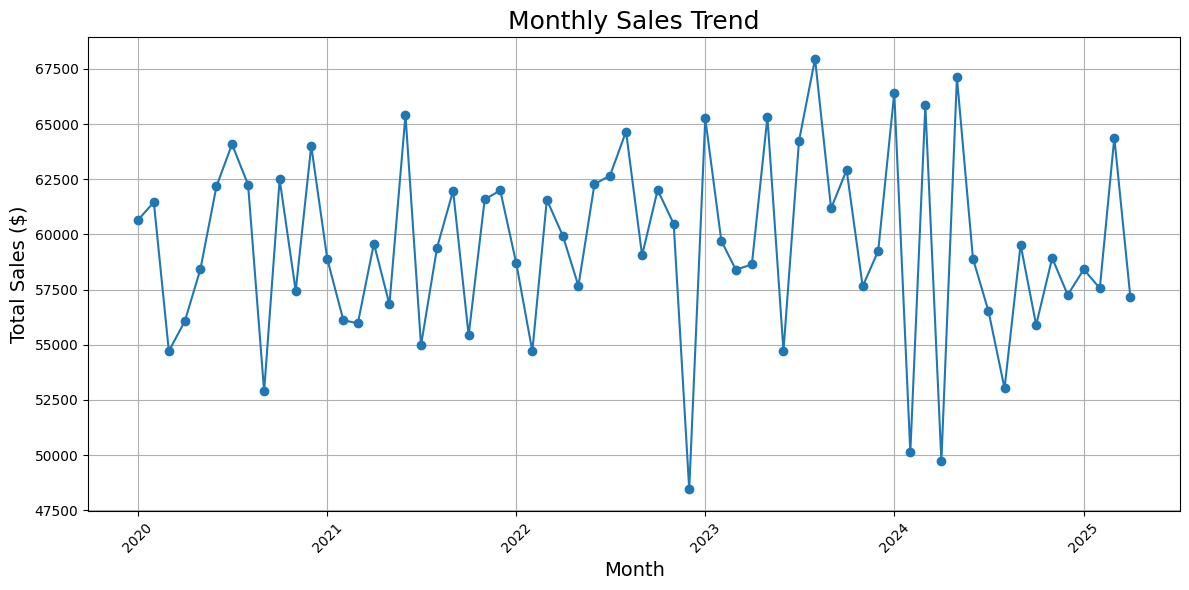

In [18]:

monthly_sales_df['order_month'] = pd.to_datetime(monthly_sales_df['order_month'])

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_df['order_month'], monthly_sales_df['total_sales'], marker='o', linestyle='-')
plt.title('Monthly Sales Trend', fontsize=18)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Sales ($)', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


plt.savefig('monthly_sales_trend.png', dpi=300)

plt.show()


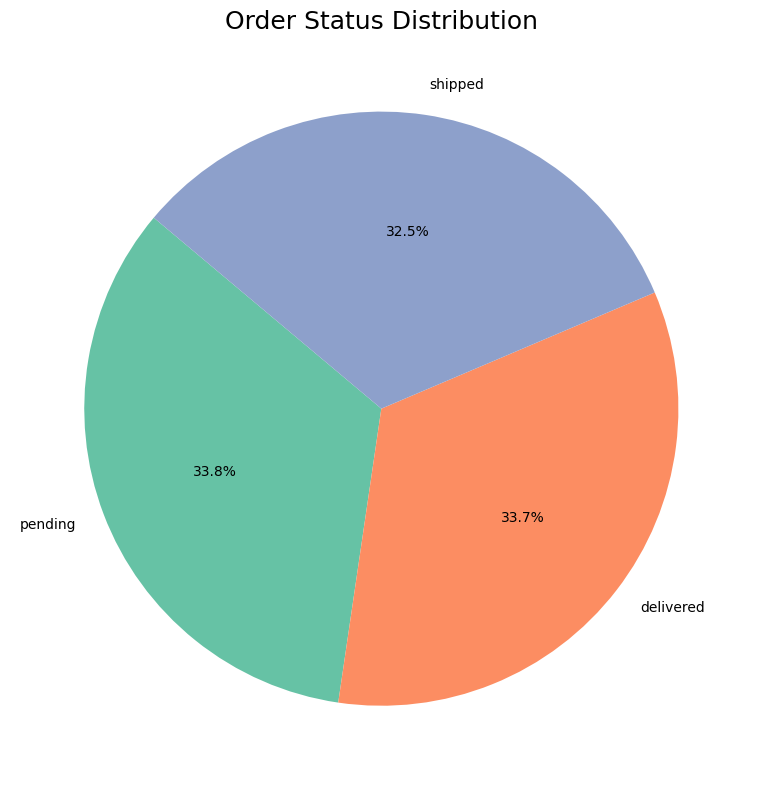

In [19]:


plt.figure(figsize=(8, 8))
plt.pie(
    order_status_df['order_count'],
    labels=order_status_df['order_status'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('Set2')
)
plt.title('Order Status Distribution', fontsize=18)
plt.tight_layout()


plt.savefig('order_status_pie_chart.png', dpi=300)

plt.show()


<ipython-input-21-c8742688e108>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='payment_status', y='payment_count', data=payment_status_df, palette='pastel')


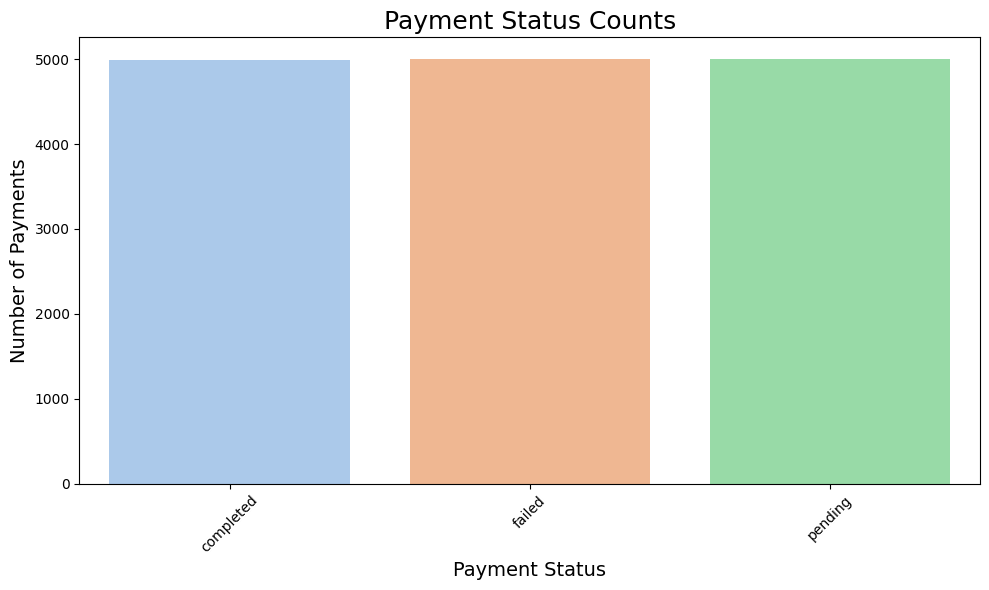

In [21]:

payment_status_df = pd.read_sql_query("""
SELECT payment_status, COUNT(*) AS payment_count
FROM payments
GROUP BY payment_status
""", conn)


plt.figure(figsize=(10, 6))
sns.barplot(x='payment_status', y='payment_count', data=payment_status_df, palette='pastel')
plt.title('Payment Status Counts', fontsize=18)
plt.xlabel('Payment Status', fontsize=14)
plt.ylabel('Number of Payments', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()


plt.savefig('payment_status_counts.png', dpi=300)

plt.show()
